<a href="https://colab.research.google.com/github/larasauser/master/blob/main/nspi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NSPI

In [46]:
#Libraries
!pip install rasterio scikit-image

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
#from skimage.util import view_as_windows

In [47]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
#load NDVI image
original_image = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/NDVI_2023-08-20.tif'
file_path = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/NDVI_2023-08-20.tif'

with rasterio.open(original_image) as src:
  ndvi_og = src.read(1).astype(np.float32)
  nodata_value_og = src.nodata

with rasterio.open(file_path) as src:
  ndvi = src.read(1).astype(np.float32)
  nodata_value = src.nodata

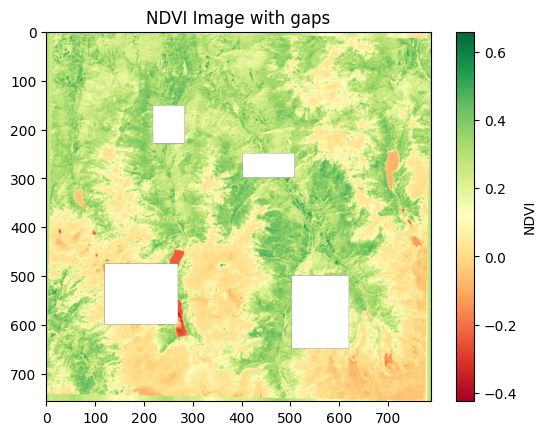

In [114]:
#Create a mask for missing pixels
if nodata_value is not None:
  mask = (ndvi == nodata_value) | (ndvi < -1.0) | (ndvi > 1.0)
else:
  mask = np.isnan(ndvi) | (ndvi < -1.0) | (ndvi > 1.0)

ndvi[mask] = np.nan

plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI Image with gaps')
plt.colorbar(label='NDVI')
plt.show()

In [115]:
#NSPI interpolation Function
def nspi_interpolation(ndvi_array, window_size=200):
  filled = ndvi_array.copy()
  rows,cols=ndvi_array.shape
  half = window_size // 2

  for i in range(rows):
    for j in range(cols):
      if np.isnan(ndvi_array[i,j]):
        r_min, r_max = max(0, i-half), min(rows, i + half +1)
        c_min, c_max = max(0, j-half), min(cols, j+half+1)

        neighborhood = ndvi_array[r_min:r_max, c_min:c_max]
        valid_mask = ~np.isnan(neighborhood)

        if np.any(valid_mask):
          valid_vals = neighborhood[valid_mask]
          valid_coords = np.argwhere(valid_mask) + [r_min, c_min]
          center = np.array([[i,j]])
          distances = cdist(center, valid_coords)[0]
          weights = 1/(distances + 1e-6)
          weights /= weights.sum()
          filled[i,j] = np.sum(valid_vals * weights)

  return filled

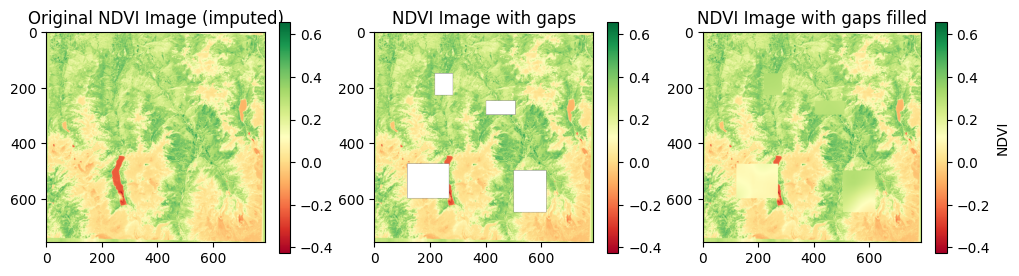

In [116]:
#Apply and visualise
filled_ndvi = nspi_interpolation(ndvi, window_size=200)


plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(ndvi_og, cmap='RdYlGn')
plt.title('Original NDVI Image (imputed)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI Image with gaps')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(filled_ndvi, cmap='RdYlGn')
plt.title('NDVI Image with gaps filled')
plt.colorbar(label='NDVI')
plt.show()

In [117]:
# Check if there are NaN values in ndvi_og
print("Any NaN values in filled:", np.any(np.isnan(filled_ndvi)))

Any NaN values in filled: False


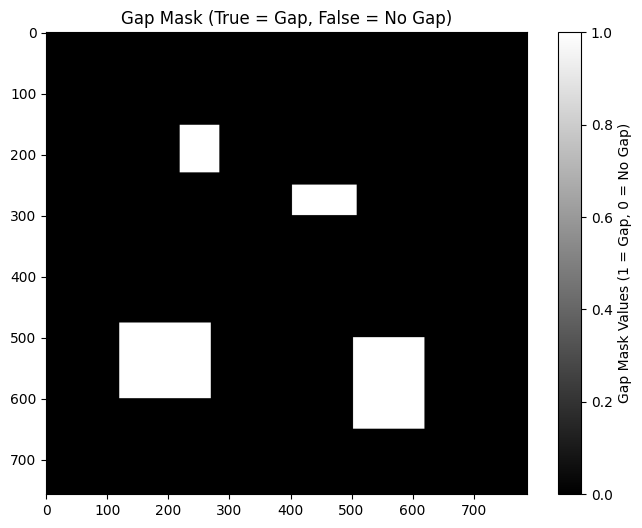

In [118]:
# Create a gap mask from the 'ndvi' image where NaN values represent gaps
gap_mask = np.isnan(ndvi) | (ndvi == -9999)

# Plot the gap mask
plt.figure(figsize=(8, 6))
plt.imshow(gap_mask, cmap='gray')  # Gray scale for visualization
plt.title("Gap Mask (True = Gap, False = No Gap)")
plt.colorbar(label="Gap Mask Values (1 = Gap, 0 = No Gap)")
plt.show()


In [119]:
# Get true values from the original NDVI (where gaps are present in the 'ndvi' image)
true_vals = ndvi_og[gap_mask]

# Get predicted values from the filled NDVI (where the gaps were filled)
pred_vals = filled_ndvi[gap_mask]

# Calculate MSE
mse = np.mean((true_vals - pred_vals)**2)
print(f'Mean Squared Error: {mse}')

# Calculate RMSE
rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R²
r2 = 1 - np.sum((true_vals - pred_vals)**2) / np.sum((true_vals - np.mean(true_vals))**2)
print(f'R²: {r2}')


Mean Squared Error: 0.01883547194302082
Root Mean Squared Error (RMSE): 0.1372423768043518
R²: 0.22969257831573486


## Adaptative window

In [120]:
import numpy as np
from scipy.ndimage import label, find_objects
from scipy.spatial.distance import cdist

def nspi_interpolation_adaptive(ndvi_array, scaling_factor=1.5):
    filled = ndvi_array.copy()
    rows, cols = ndvi_array.shape

    # Étape 1 : identifier les "trous" (zones contiguës de NaNs)
    nan_mask = np.isnan(ndvi_array)
    labeled_mask, num_features = label(nan_mask)
    slices = find_objects(labeled_mask)

    for label_idx, slc in enumerate(slices):
        if slc is None:
            continue

        row_start, row_end = slc[0].start, slc[0].stop
        col_start, col_end = slc[1].start, slc[1].stop

        height = row_end - row_start
        width = col_end - col_start
        max_dim = max(height, width)

        # Taille de la fenêtre adaptative
        window_size = int(scaling_factor * max_dim)
        half = window_size // 2

        # Trou actuel (indices des pixels NaNs)
        coords = np.argwhere(labeled_mask == (label_idx + 1))

        for (i, j) in coords:
            r_min, r_max = max(0, i - half), min(rows, i + half + 1)
            c_min, c_max = max(0, j - half), min(cols, j + half + 1)

            neighborhood = ndvi_array[r_min:r_max, c_min:c_max]
            valid_mask = ~np.isnan(neighborhood)

            if np.any(valid_mask):
                valid_vals = neighborhood[valid_mask]
                valid_coords = np.argwhere(valid_mask) + [r_min, c_min]
                center = np.array([[i, j]])
                distances = cdist(center, valid_coords)[0]
                weights = 1 / (distances + 1e-6)
                weights /= weights.sum()
                filled[i, j] = np.sum(valid_vals * weights)

    return filled


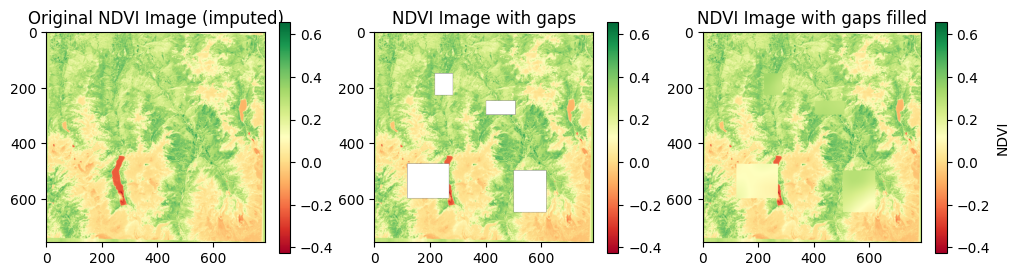

In [121]:
#Apply and visualise
filled_ndvi = nspi_interpolation_adaptive(ndvi)


plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(ndvi_og, cmap='RdYlGn')
plt.title('Original NDVI Image (imputed)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI Image with gaps')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(filled_ndvi, cmap='RdYlGn')
plt.title('NDVI Image with gaps filled')
plt.colorbar(label='NDVI')
plt.show()

In [122]:
# Check if there are NaN values in ndvi_og
print("Any NaN values in filled:", np.any(np.isnan(filled_ndvi)))

Any NaN values in filled: False


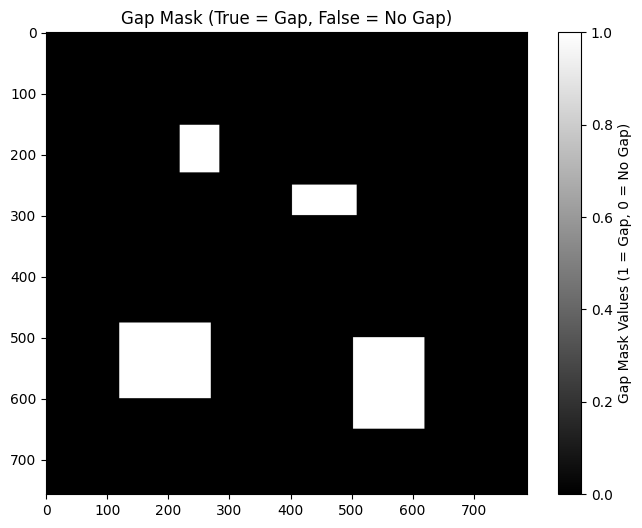

In [123]:
# Create a gap mask from the 'ndvi' image where NaN values represent gaps
gap_mask = np.isnan(ndvi) | (ndvi == -9999)

# Plot the gap mask
plt.figure(figsize=(8, 6))
plt.imshow(gap_mask, cmap='gray')  # Gray scale for visualization
plt.title("Gap Mask (True = Gap, False = No Gap)")
plt.colorbar(label="Gap Mask Values (1 = Gap, 0 = No Gap)")
plt.show()


In [124]:
# Get true values from the original NDVI (where gaps are present in the 'ndvi' image)
true_vals = ndvi_og[gap_mask]

# Get predicted values from the filled NDVI (where the gaps were filled)
pred_vals = filled_ndvi[gap_mask]

# Calculate MSE
mse = np.mean((true_vals - pred_vals)**2)
print(f'Mean Squared Error: {mse}')

# Calculate RMSE
rmse = np.sqrt(np.mean((true_vals - pred_vals)**2))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R²
r2 = 1 - np.sum((true_vals - pred_vals)**2) / np.sum((true_vals - np.mean(true_vals))**2)
print(f'R²: {r2}')


Mean Squared Error: 0.018927672877907753
Root Mean Squared Error (RMSE): 0.1375778764486313
R²: 0.2259218692779541
